# Finding Neptune using Uranus

Note :
  -  For better understanding of this notebook, refer to the [md_file](https://github.com/inlab-geo/cofi-examples/blob/main/theory/finding_neptune_bayesian.md) designed specifically for this notebook and better insights into the theory.

  - The import methods and functions from [neptune_bayesian_methods](https://github.com/inlab-geo/cofi-examples/blob/main/theory/finding_neptune_deterministic.md), [neptune_deterministic_methods](https://github.com/inlab-geo/cofi-examples/blob/main/theory/finding_neptune_deterministic.md) and [setup_inversion](https://github.com/inlab-geo/cofi-examples/blob/main/theory/finding_neptune_deterministic.md) are used to set up the simulation and perform the necessary calculations.

In [ ]:
# This notebook requires the following libraries to run, in order to install them uncomment the lines below
# %pip install cofi
# %pip install numba
# %pip install tqdm
# %pip install matplotlib
# %pip install astroquery

## 1. Introduction

- The following Notebook is based on the historical problem on how Neptune was found by Johann Galle using mathematical predictions made independently by two astronomers:

  - Urbain Le Verrier (France)

  - John Couch Adams (England)
  
  Through this Notebook we wish to demostrate how `CoFI` can be used to solve this problem via deterministic inversion.
  For more details on this problem, see the following [thesis](www.diva-portal.org/smash/get/diva2:1218549/FULLTEXT01.pdf)

- In the following notebook we discuss the problem of finding Neptune's mass, its velocity components and its position coordinates in the year 1775, by modeling the trajectory of Uranus with and without the influence of Neptune.     

- We define $ g(m) $, our forward model, as vector-valued function that predicts the position coordinates of Uranus at each observation time $t_j$, as a function of Neptune's parameters $m$:

    $$
     g(m) =
    \begin{bmatrix}
    \hat x_1(m) \\
    \vdots \\
    \hat x_N(m) \\
    \hat y_1(m) \\
    \vdots \\
    \hat y_N(m) \\
    \hat z_1(m) \\
    \vdots \\
    \hat z_N(m)
    \end{bmatrix}
    \in \mathbb{R}^{3M \times 1}
    $$
    where $ N $ is the number of data points, and $ \hat x_j(m), \ \hat y_j(m), \ \hat z_j(m) $ are the coordinates of Uranus at data point $ j \ = \ 1, \ 2, \ .... \ N$ as a function of Neptune's parameters $ m $,        
    where $m = (m_M, m_x, m_y, m_z, {m_{v_x}}, m_{v_y}, m_{v_z})$ is the set of parameters describing Neptune's mass ($m_M$), its position coordinates $(m_x, m_y, m_z)$ and its velocity components $(m_{v_x}, m_{v_y}, m_{v_z})$
    

    and $d$ as the data vector of positions of Uranus at different time steps:  
    $$
    d =
    \begin{bmatrix}
    x_1 \\
    \vdots \\
    x_N \\
    y_1 \\
    \vdots \\
    y_N \\
    z_1 \\
    \vdots \\
    z_N
    \end{bmatrix}
    \in \mathbb{R}^{3M \times 1}
    $$
    where $ N $ is the number of data points, and $ \hat x_j, \ \hat y_j, \ \hat z_j $ are the true coordinates of Uranus at data point $ j \ = \ 1, \ 2, \ .... \ N$.
    
 - hence our problem formulation changes to : 
  $$
    \underset{m}{\min}   || g(m) - {d} ||_{2}^2 
  $$


## 2. Problem Setting

- We use **Newton's Law of gravitation** to compute the gravitational force acting on a planet due to other celestial bodies.

- This formulation uses Newton’s Law of Universal Gravitation to model the **net gravitational influence** from multiple bodies on a single target planet.


- Let $r$ be the vector containing the positions of all planets and $a$ be the vector containing the accelerations of all planets.

    
    The velocity and acceleration vectors are defined as:

    $$
    \dot{\mathbf{r}} = \mathbf{v}, \quad \ddot{\mathbf{r}} = \mathbf{a}
    $$

    where

    $$
    \mathbf{r} = 
    \begin{bmatrix}
    \mathbf{r}_1 \\
    \vdots \\
    \mathbf{r}_9
    \end{bmatrix}, \quad
    \mathbf{a} = 
    \begin{bmatrix}
    \mathbf{a}_1 \\
    \vdots \\
    \mathbf{a}_9
    \end{bmatrix}, \quad
    \mathbf{r}, \mathbf{a} \in \mathbb{R}^{27 \times 1}
    $$

- This results in the system of differential equations:

    $$
    \frac{d}{dt}
    \begin{bmatrix}
    \mathbf{r}(t) \\
    \mathbf{v}(t)
    \end{bmatrix}
    = 
    \begin{bmatrix}
    \mathbf{v}(t) \\
    \mathbf{a}(t)
    \end{bmatrix}
    $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Callable
import copy
from numba import njit, jit
import warnings
import multiprocessing as mp
import time
import subprocess
import arviz as az
from astroquery.jplhorizons import Horizons
warnings.filterwarnings('ignore')



from cofi import BaseProblem, InversionOptions, Inversion

np.random.seed(42)

- We solve our ODEs with the **Runge-Kutta 4 (RK4)** method, which is an explicit and iterative method, well-suited for initial value problems.


- In the following cell, we import -  `acceleration` and `rk4_step` to serve as functions for our forward model.

- We now demostrate our forward model, using the above defined functions, in the `run_simulation` method defined below, which helps us run a simulation of solar system.



- Throughout this notebook for the purpose of our inversion, we are going to define mass in terms of solar masses, positions coordinates in **Astonomical Units (AU)** and velocities for planets in **Au/day**

Computing trajectories...: 100%|██████████| 36500/36500 [00:00<00:00, 42828.10it/s]


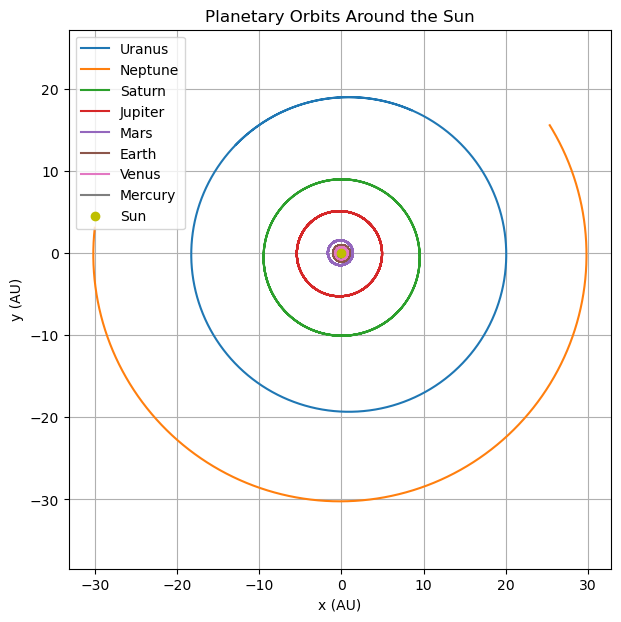

In [2]:
from neptune_deterministic_methods import acceleration, rk4_step, run_simulation
trajectories = run_simulation(T = 100, dt = 1, plot_only=['Uranus', 'Neptune', 'Saturn', 'Jupiter', 'Mars', 'Earth', 'Venus', 'Mercury'])

## 2.1 Bayesian Inversion via the Stretch Move

In this notebook, we use `CoFI`  to perform Bayesian inversion. Specifically, we use the **stretch move** ensemble sampler introduced by goodman & Weare (2010), which is well-suited for exploring complex, high-dimensional posterior distributions.

MCMC is a method to sample from the **posterior distribution** of model parameters $\mathbf{m}$ given observed data $\mathbf{d}$. According to Bayes' theorem:

$$
\tag{1}
p(\mathbf{m} \mid \mathbf{d}) \propto p(\mathbf{d} \mid \mathbf{m}) \, p(\mathbf{m}),
$$

where:

- $p(\mathbf{m} \mid \mathbf{d})$ is the **posterior** probability of the model,
- $p(\mathbf{d} \mid \mathbf{m})$ is the **likelihood**, and
- $p(\mathbf{m})$ is the **prior**.

The likelihood measures how well a model explains the data. 

In the stretch move algorithm, a population of walkers explores the posterior distribution simultaneously. Each walker proposes new positions based on the positions of other walkers, allowing for more efficient exploration of complex posteriors.

The sampling proceeds in the following steps:

1. Initialize a set of walkers in parameter space.
2. At each iteration, propose new positions for each walker using the stretch move.
3. Accept or reject the proposed positions based on the Metropolis criterion.
4. After a **burn-in** period, the samples from all walkers are collected to approximate the posterior.

This method yields not only the most likely model but also the full distribution over model space, capturing uncertainty in the inferred parameters.


## 3. Inversion on Synthetic Data

- We will first demonstrate bayesian inversion using `CoFI` on synthetic data. 

- The synthetic observations are generated by integrating our gravitational forward model with a fourth-order Runge-Kutta (`RK4`) solver to simulate Uranus's trajectory under the influence of Neptune.


- We simulate observational noise by sampling from zero-mean Gaussian distributions with specified variances for each coordinate:

$$
x_\text{obs} = x + \epsilon_x, \quad y_\text{obs} = y + \epsilon_y, \quad z_\text{obs} = z + \epsilon_z
$$

- where

- $$
    \epsilon_x \sim \mathcal{N}(0, \sigma_x^2), \quad 
    \epsilon_y \sim \mathcal{N}(0, \sigma_y^2), \quad 
    \epsilon_z \sim \mathcal{N}(0, \sigma_z^2)
  $$

- with noise levels set as

- $$
  \sigma_x = \sigma_y = 10^{-3}, \quad \sigma_z = 10^{-5}
  $$

- The function below generates the synthetic data with the specified noise levels.

## 3.1 Generating synthetic data

In [3]:
from neptune_deterministic_methods import generate_synthetic_data

T = 190 # time for which we want to generate synthetic data
z_scale_factor = 1
dt = 1

U_true = generate_synthetic_data(T = T, 
                                 dt = dt, 
                                 z_scaling = False, 
                                 add_noise = True, 
                                 noise_level = np.array([0.001, 0.001, 0.00001]))

Computing trajectories...: 100%|██████████| 68985/68985 [00:00<00:00, 141563.44it/s]



Synthetic data ranges:
X: -18.298 to 20.084 (range: 38.383)
Y: -19.319 to 19.019 (range: 38.337)
Z: -0.272199 to 0.248322 (range: 0.520521)

Noisy synthetic data ranges:
X: -18.299 to 20.084 (range: 38.383)
Y: -19.321 to 19.020 (range: 38.340)
Z: -0.272212 to 0.248322 (range: 0.520534)


- The cell below sets up the starting model for our walkers/chains in MCMC and some pre-defined scales to be used for scaling while running our inversion, to ensure that all parameters are roughly on the same scale or at least near to each other.

- For our bayesian inversion we first scale all the parameters and the convert our mass to log mass. This ensures that all our parameters are in the same scale.

In [4]:
# True/reference parameters for Neptune [mass, x, y, z, vx, vy, vz]
from setup_inversion import get_inversion_indices, set_true_m, get_param_bounds, get_param_scales, set_initial_conditions, get_starting_points     

m_0 = set_true_m()
initial_conditions = set_initial_conditions()

PARAM_BOUNDS = get_param_bounds()
PARAM_SCALES = get_param_scales()
INVERT_INDICES = get_inversion_indices()
STARTING_POINTS = get_starting_points()


In [5]:
from setup_inversion import scale_param, unscale_param, validate_config

validate_config()

Inverting for: ['mass', 'x', 'y', 'z', 'vx', 'vy', 'vz']
Starting points: [5.129494593915012e-05, -29.91585533802299, 3.145551080953517, 0.1050744172524112, -0.0002804329678559355, -0.00311021549555015, 4.187313350941659e-05]


In [6]:
names = list(initial_conditions.keys())
n_bodies = len(names)
uranus_idx = names.index("Uranus")

In [9]:
from neptune_bayesian_methods import predict_U

In [10]:
m_start_scaled = scale_param(m_0)

if 0 in INVERT_INDICES:
    m_start_scaled[0] = np.log10(m_start_scaled[0])  # Convert mass to log scale

if len(INVERT_INDICES) == 1:
    m_start_scaled = m_start_scaled.item() if hasattr(m_start_scaled, 'item') else m_start_scaled

print(f"\nStarting points (unscaled): {STARTING_POINTS}")
print(f"Starting points (scaled): {m_start_scaled}")

print("\nTesting forward function...")
try:
    pred_test = predict_U(m_start_scaled, T = T, dt = dt, z_scale_factor = z_scale_factor)
    residual_test = pred_test - U_true
    print(f"Initial residual norm: {np.linalg.norm(residual_test):.6f}")
    print(f"Residual by component:")
    print(f"  X component: {np.linalg.norm(residual_test[:T]):.6f}")
    print(f"  Y component: {np.linalg.norm(residual_test[T:2*T]):.6f}")
    print(f"  Z component: {np.linalg.norm(residual_test[2*T:]):.6f}")
except Exception as e:
    print(f"Forward function test failed: {e}")
    import traceback
    traceback.print_exc()


Starting points (unscaled): [5.129494593915012e-05, -29.91585533802299, 3.145551080953517, 0.1050744172524112, -0.0002804329678559355, -0.00311021549555015, 4.187313350941659e-05]
Starting points (scaled): [-3.73377762 -4.61564393  0.42847056  0.40820822 -0.27220634 -3.73292208
  0.00484093]

Testing forward function...
Initial residual norm: 0.019639
Residual by component:
  X component: 0.013658
  Y component: 0.014112
  Z component: 0.000148


## 3.2 Running the Inversion on Synthetic Data

- Defined below are our `log prior` and `log likelihood` functions.

- We set a uniform prior on log of our mass and all the other parameters (Neptune's position coordinates and velocity components).

In [11]:
param_bounds_lower = np.array([bound[0] for bound in PARAM_BOUNDS])
param_bounds_upper = np.array([bound[1] for bound in PARAM_BOUNDS])

bounds_lower_scaled = scale_param(param_bounds_lower)
bounds_upper_scaled = scale_param(param_bounds_upper)

bounds_lower_scaled[0] = np.log10(bounds_lower_scaled[0])  # Convert mass back to log scale
bounds_upper_scaled[0] = np.log10(bounds_upper_scaled[0])  # Convert mass back to log scale

sigma_x = 5e-2          # Standard deviation for X position in uranus orbit data, taken one order higher than the noise added
sigma_y = 5e-2          # Standard deviation for Y position in uranus orbit data, taken one order higher than the noise added
sigma_z = 1e-3           # Standard deviation for Z position in uranus orbit data, taken two orders higher than the noise added

diagonal_values = [1/sigma_x**2]*T + [1/sigma_y**2]*T + [1/sigma_z**2]*T
inv_variances = np.array(diagonal_values)

In [12]:
def my_log_likelihood(m_scaled : np.ndarray, U_true : np.ndarray) -> float:
    
    """
    Log-likelihood function for Bayesian inversion

    Parameters
    ----------
    m_scaled : np.array
        Scaled parameters being inverted.
    U_true : np.array
        True Uranus positions in the format [x, y, z] scaled by z_scale_factor.
    Returns
    -------
    log_likelihood : float
        The log-likelihood value, or -inf if the prediction fails or residuals are not finite.
    """
    m_scaled = np.atleast_1d(m_scaled).astype(np.float64)

    try:
        y_hat = predict_U(m_scaled, T = T, dt = dt, z_scale_factor = z_scale_factor)
        if not np.isfinite(y_hat).all():
            return -np.inf
        residuals = U_true - y_hat
        if residuals.shape != U_true.shape:
            return -np.inf
        return -0.5 * np.sum(residuals**2 * inv_variances)
    
    except (ValueError, ArithmeticError):
        return -np.inf
    except Exception as e:
        print(f"Error in log-likelihood calculation: {e}")
        return -np.inf

def my_log_prior(m_scaled : np.ndarray) -> float:
    """
    Log-prior function for Bayesian inversion

    Parameters
    ----------
    m_scaled : np.ndarray
        Scaled parameters being inverted.

    Returns
    -------
    float
        The log prior value, or -inf if the parameters are out of bounds.
    """
    m_scaled = np.atleast_1d(m_scaled)
    if np.any(m_scaled < bounds_lower_scaled) or np.any(m_scaled > bounds_upper_scaled):
        return -np.inf
    return 0

In [ ]:
n_walkers = 20
n_dim = len(INVERT_INDICES)  
nsteps = 10000

print(f"Optimized setup: {len(inv_variances)} inverse variance values")

print("Parameter bounds (unscaled):")
print("  Lower:", param_bounds_lower)
print("  Upper:", param_bounds_upper)
print("Scaled bounds:")
print("  Lower:", bounds_lower_scaled)
print("  Upper:", bounds_upper_scaled)

print(f"Number of dimensions: {n_dim}")

starting_lower_bounds = m_start_scaled - 10
starting_upper_bounds = m_start_scaled + 10

walkers_start = np.random.uniform(    # you may use uniform starting point for all the walkers
    starting_lower_bounds,
    starting_upper_bounds,
    size=(n_walkers, n_dim)
)

print("Initial state shape:", walkers_start.shape)

for i, w in enumerate(walkers_start):
    ll = my_log_likelihood(w, U_true)
    if not np.isfinite(ll):
        print(f"Invalid log-likelihood at walker {i}: {w}, ll = {ll}")
        
for i, w in enumerate(walkers_start):
    # Clip each parameter to its bounds
    walkers_start[i] = np.clip(w, bounds_lower_scaled, bounds_upper_scaled)
    
    # Check if clipping was applied
    if not np.array_equal(w, walkers_start[i]):
        print(f"Walker {i} clipped from {w} to {walkers_start[i]}")

print("All walkers are now within bounds.")

# Verify all walkers are within bounds
for i, w in enumerate(walkers_start):
    if not np.isfinite(my_log_prior(w)):
        print(f"ERROR: Walker {i} still outside prior bounds: {w}")
    else:
        ll = my_log_likelihood(w, U_true)
        if not np.isfinite(ll):
            print(f"WARNING: Walker {i} has invalid log-likelihood: {ll}")
            
            
caffeinate_proc = subprocess.Popen(["caffeinate", "-i"])    # to ensure the process doesn't sleep

inv_problem = BaseProblem()
inv_problem.name = "Neptune Orbit Determination - Config Driven"
inv_problem.set_data(U_true)
inv_problem.set_forward(predict_U)
inv_problem.set_initial_model(np.atleast_1d(m_start_scaled))
inv_problem.set_log_prior(my_log_prior)
inv_problem.set_log_likelihood(my_log_likelihood, args=(U_true,))
inv_problem.set_model_shape(n_dim)


try:
    mp.set_start_method('fork', force=True)  # if this doesnt work then use 'spawn' method instead
    
    with mp.Pool() as pool:

        inv_options = InversionOptions()
        inv_options.set_tool("emcee")
        inv_options.set_params(
            nwalkers=n_walkers,
            nsteps=nsteps,
            initial_state=walkers_start,
            progress=True,
            pool=pool,
            # moves=move
        )        
        inv = Inversion(inv_problem, inv_options)
        start = time.time()
                
        inv_result = inv.run()
        end = time.time()
        
        print(f"OPTIMIZED Inversion completed in {end - start:.2f} seconds using `emcee`.")
        print(f"The inversion result from `emcee`:")
        inv_result.summary()
        
finally:
    caffeinate_proc.terminate()
    print("Sleep prevention deactivated.")


Optimized setup: 570 inverse variance values
Parameter bounds (unscaled):
  Lower: [ 1.e-08 -5.e+01 -5.e+01 -1.e+01 -1.e-03 -1.e-02 -1.e-03]
  Upper: [1.e-03 5.e+01 5.e+01 1.e+01 1.e-03 1.e-02 1.e-03]
Scaled bounds:
  Lower: [ -7.44566917  -7.67844126  -6.8918876   -6.49935872  -0.79949471
 -12.03003616  -0.06734446]
  Upper: [-2.44566917  7.67844126  6.8918876   6.49935872  0.79949471 12.03003616
  0.06734446]
Number of dimensions: 7
Initial state shape: (20, 7)
All walkers are now within bounds.


100%|██████████| 10000/10000 [3:30:29<00:00,  1.26s/it] 

OPTIMIZED Inversion completed in 12631.23 seconds using `emcee`.
The inversion result from `emcee`:
Summary for inversion result
SUCCESS
----------------------------
sampler: <emcee.ensemble.EnsembleSampler object>
blob_names: ['log_likelihood', 'log_prior']
Sleep prevention deactivated.


## 3.3 Getting the acceptance rates and auto-correlation times

In [ ]:
import arviz as az
print("\n" + "="*50)
print("RESULTS SUMMARY")
print("="*50)

param_names = ['mass', 'x', 'y', 'z', 'vx', 'vy', 'vz']

sampler = inv_result.sampler  

az_idata = inv_result.to_arviz()
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm

n_trajectory_samples = 10000
discard_burn = 0
thin_interval = 10
flat_samples = sampler.get_chain( flat=True, thin = thin_interval)
trajectory_indices = np.random.randint(len(flat_samples), size=n_trajectory_samples)
selected_samples = flat_samples[trajectory_indices]


reference_values_scaled = scale_param(m_0)

acceptance_rates = sampler.acceptance_fraction
mean_acceptance = np.mean(acceptance_rates)
print(f"Mean acceptance rate: {mean_acceptance:.3f}")
print(f"Acceptance rate per walker:")
for i, acc in enumerate(acceptance_rates):
    print(f"  Walker {i:2d}: {acc:.3f}")

print(f"\nAcceptance rate statistics:")
print(f"  Range: {np.min(acceptance_rates):.3f} - {np.max(acceptance_rates):.3f}")
print(f"  Std dev: {np.std(acceptance_rates):.3f}")


autocorr_times = sampler.get_autocorr_time(discard=300, quiet=True)
max_autocorr = np.max(autocorr_times)
mean_autocorr = np.mean(autocorr_times)

labels = ["m", "x", "y", "z", "vx", "vy", "vz"]
print("Autocorrelation times by parameter:")
for i, (label, tau) in enumerate(zip(labels, autocorr_times)):
    print(f"  {label:>3s}: {tau:6.1f} steps")

print(f"\nAutocorrelation statistics:")
print(f"  Mean τ: {mean_autocorr:.1f} steps")
print(f"  Max τ:  {max_autocorr:.1f} steps")



RESULTS SUMMARY
Mean acceptance rate: 0.139
Acceptance rate per walker:
  Walker  0: 0.143
  Walker  1: 0.149
  Walker  2: 0.111
  Walker  3: 0.152
  Walker  4: 0.154
  Walker  5: 0.137
  Walker  6: 0.125
  Walker  7: 0.154
  Walker  8: 0.153
  Walker  9: 0.128
  Walker 10: 0.101
  Walker 11: 0.140
  Walker 12: 0.131
  Walker 13: 0.138
  Walker 14: 0.148
  Walker 15: 0.133
  Walker 16: 0.159
  Walker 17: 0.121
  Walker 18: 0.143
  Walker 19: 0.156

Acceptance rate statistics:
  Range: 0.101 - 0.159
  Std dev: 0.015


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 194;
tau: [ 828.40692974 1058.5967114  1049.45158354  630.05269076  866.13399577
  838.37594524  565.3856792 ]


Autocorrelation times by parameter:
    m:  828.4 steps
    x: 1058.6 steps
    y: 1049.5 steps
    z:  630.1 steps
   vx:  866.1 steps
   vy:  838.4 steps
   vz:  565.4 steps

Autocorrelation statistics:
  Mean τ: 833.8 steps
  Max τ:  1058.6 steps


## 3.4 Plotting the Posteriors

- We now plot the posteriors and along with that, we alsomark the true parameter values of Neptune using a black 'X' mark.

- Note that all our parameters are scaled.

Creating corner plot with KDE contours and reference values...


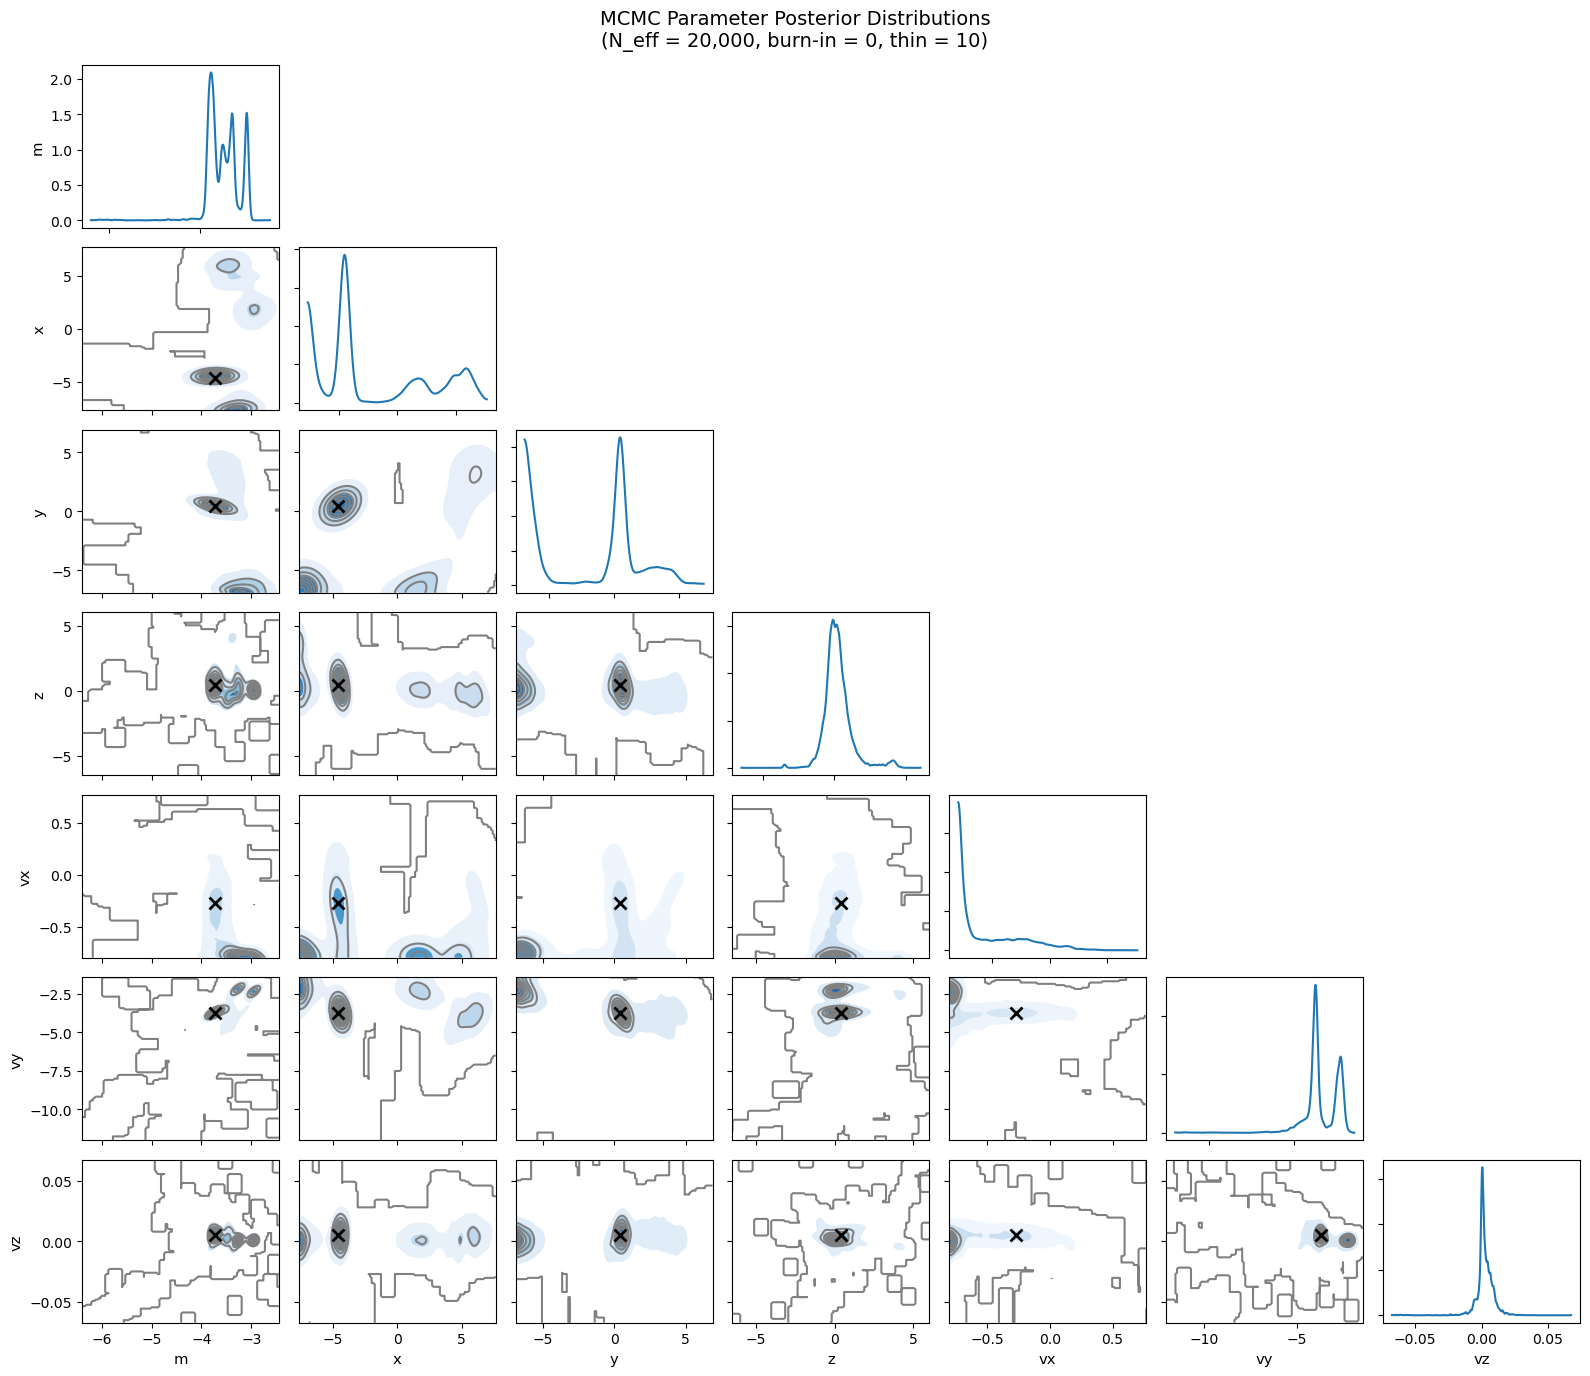

In [ ]:
reference_values_scaled = scale_param(m_0)
reference_values_scaled[0] = np.log10(reference_values_scaled[0])  # Scale mass logarithmically
param_labels = ['m', 'x', 'y', 'z', 'vx', 'vy', 'vz']
param_data = {label: flat_samples[:, i] for i, label in enumerate(param_labels)}
reference_dict = {label: reference_values_scaled[i] for i, label in enumerate(param_labels)}

print("Creating corner plot with KDE contours and reference values...")

fig, axes = plt.subplots(7, 7, figsize=(16, 14))

az.plot_pair(
    param_data,
    marginals=True,
    reference_values=reference_dict,
    reference_values_kwargs={
        'color': 'red', 
        'ms': 8,
        'marker': 'x',
        'markeredgewidth': 2
    },
    kind='kde',
    kde_kwargs={
        'hdi_probs': [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
        'contourf_kwargs': {'cmap': 'Blues'},
    },
    ax=axes,
    textsize=10
)

plt.suptitle(f'MCMC Parameter Posterior Distributions\n'
            f'(N_eff = {len(flat_samples):,}, burn-in = {discard_burn}, thin = {thin_interval})', 
            fontsize=14, y=0.98)

plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()


## 3.5 Plotting the Chains

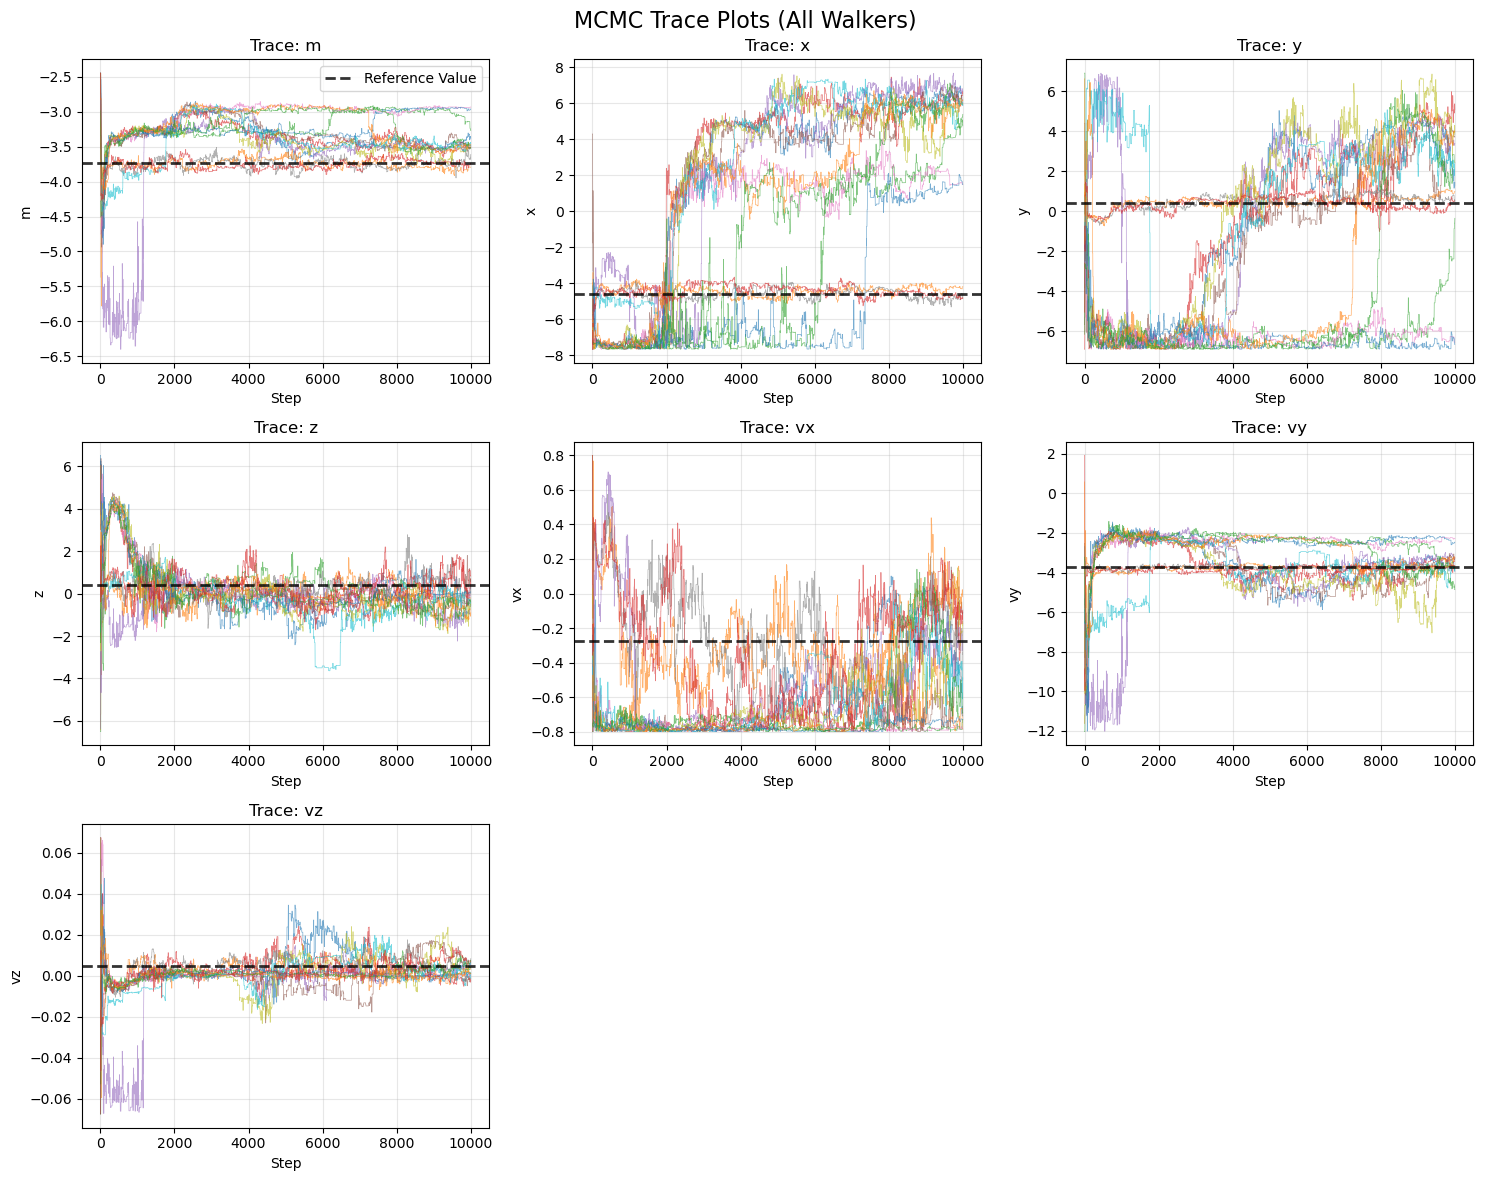

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

chain_full = sampler.get_chain()
labels = ["m", "x", "y", "z", "vx", "vy", "vz"]

for i in range(n_dim):
    ax = axes[i]
    
    for walker in range(14):
        ax.plot(chain_full[:, walker, i], alpha=0.6, linewidth=0.5)
    
    ax.axhline(reference_values_scaled[i], color='black', linestyle='--', alpha=0.8, 
            linewidth=2, label='Reference Value' if i == 0 else '')    
    ax.set_xlabel('Step')
    ax.set_ylabel(f'{labels[i]}')
    ax.set_title(f'Trace: {labels[i]}')
    ax.grid(True, alpha=0.3)
    
    if i == 0:
        ax.legend()

for i in range(n_dim, len(axes)):
    axes[i].remove()

plt.suptitle('MCMC Trace Plots (All Walkers)', fontsize=16)
plt.tight_layout()
plt.show()

## 4. Real Data Inversion

- We then apply our deterministic inversion via CoFI on actual observational data obtained from [NASA JPL Horizons](https://ssd.jpl.nasa.gov/horizons/app.html#/).

- The data consists of geometric Cartesian position and velocity vectors of **Uranus**, relative to the **Solar System Barycenter**, with the following settings:

  - **Target body**: Uranus (799)  
  - **Center body**: Solar System Barycenter (0)  
  - **Reference frame**: Ecliptic of J2000.0  
  - **Time span**: A.D. 1775-Jan-01 to 2125-Jan-02  
  - **Step size**: 1 calendar year  
  - **Output format**: Cartesian position and velocity (AU, AU/day)  
  - **Output type**: GEOMETRIC states  
  - **Calendar mode**: Mixed Julian/Gregorian  
  - **Ephemeris source**: `ura183_merged` (Uranus), `DE441` (Solar System)

This dataset provides real-world observations to test the robustness of our inversion pipeline.


In [ ]:
#uncomment to install the astroquery package
# !pip install astroquery

## 4.1 Getting the actual data from NASA

In [ ]:
from neptune_deterministic_methods import get_actual_data
U_true = get_actual_data(z_scaling = False, T = 190)

## 4.2 Setting the Inversion and Running it

In [ ]:
param_bounds_lower = np.array([bound[0] for bound in PARAM_BOUNDS])
param_bounds_upper = np.array([bound[1] for bound in PARAM_BOUNDS])

bounds_lower_scaled = scale_param(param_bounds_lower)
bounds_upper_scaled = scale_param(param_bounds_upper)

bounds_lower_scaled[0] = np.log10(bounds_lower_scaled[0])  # Convert mass back to log scale
bounds_upper_scaled[0] = np.log10(bounds_upper_scaled[0])  # Convert mass back to log scale

sigma_x = 7.5e-2          # Standard deviation for X position in uranus orbit data, works best on real data
sigma_y = 1e-1          # Standard deviation for Y position in uranus orbit data, works best on real data
sigma_z = 1e-3          # Standard deviation for Z position in uranus orbit data, works best on real data

diagonal_values = [1/sigma_x**2]*T + [1/sigma_y**2]*T + [1/sigma_z**2]*T
inv_variances = np.array(diagonal_values)

In [ ]:
n_walkers = 20
n_dim = len(INVERT_INDICES)  
nsteps = 80000

print(f"Optimized setup: {len(inv_variances)} inverse variance values")

print("Parameter bounds (unscaled):")
print("  Lower:", param_bounds_lower)
print("  Upper:", param_bounds_upper)
print("Scaled bounds:")
print("  Lower:", bounds_lower_scaled)
print("  Upper:", bounds_upper_scaled)

print(f"Number of dimensions: {n_dim}")


starting_lower_bounds = m_start_scaled - 10
starting_upper_bounds = m_start_scaled + 10

walkers_start = np.random.uniform(    # you may use uniform starting point for all the walkers
    starting_lower_bounds,
    starting_upper_bounds,
    size=(n_walkers, n_dim)
)


print("Initial state shape:", walkers_start.shape)

for i, w in enumerate(walkers_start):
    ll = my_log_likelihood(w, U_true)
    if not np.isfinite(ll):
        print(f"Invalid log-likelihood at walker {i}: {w}, ll = {ll}")
        
for i, w in enumerate(walkers_start):
    # Clip each parameter to its bounds
    walkers_start[i] = np.clip(w, bounds_lower_scaled, bounds_upper_scaled)
    
    # Check if clipping was applied
    if not np.array_equal(w, walkers_start[i]):
        print(f"Walker {i} clipped from {w} to {walkers_start[i]}")

print("All walkers are now within bounds.")

# Verify all walkers are within bounds
for i, w in enumerate(walkers_start):
    if not np.isfinite(my_log_prior(w)):
        print(f"ERROR: Walker {i} still outside prior bounds: {w}")
    else:
        ll = my_log_likelihood(w, U_true)
        if not np.isfinite(ll):
            print(f"WARNING: Walker {i} has invalid log-likelihood: {ll}")
            
            
caffeinate_proc = subprocess.Popen(["caffeinate", "-i"])    # to ensure the process doesn't sleep

inv_problem = BaseProblem()
inv_problem.name = "Neptune Orbit Determination - Config Driven"
inv_problem.set_data(U_true)
inv_problem.set_forward(predict_U)
inv_problem.set_initial_model(np.atleast_1d(m_start_scaled))
inv_problem.set_log_prior(my_log_prior)
inv_problem.set_log_likelihood(my_log_likelihood, args=(U_true,))
inv_problem.set_model_shape(n_dim)


try:
    mp.set_start_method('fork', force=True)  # if this doesnt work then use 'spawn' method instead
    
    with mp.Pool() as pool:

        inv_options = InversionOptions()
        inv_options.set_tool("emcee")
        inv_options.set_params(
            nwalkers=n_walkers,
            nsteps=nsteps,
            initial_state=walkers_start,
            progress=True,
            pool=pool,
            # moves=move
        )        
        inv = Inversion(inv_problem, inv_options)
        start = time.time()
                
        inv_result = inv.run()
        end = time.time()
        
        print(f"OPTIMIZED Inversion completed in {end - start:.2f} seconds using `emcee`.")
        print(f"The inversion result from `emcee`:")
        inv_result.summary()
        
finally:
    caffeinate_proc.terminate()
    print("Sleep prevention deactivated.")


Optimized setup: 570 inverse variance values
Parameter bounds (unscaled):
  Lower: [ 1.e-08 -5.e+01 -5.e+01 -1.e+01 -1.e-03 -1.e-02 -1.e-03]
  Upper: [1.e-03 5.e+01 5.e+01 1.e+01 1.e-03 1.e-02 1.e-03]
Scaled bounds:
  Lower: [ -7.44566917  -7.67844126  -6.8918876   -6.49935872  -0.79949471
 -12.03003616  -0.06734446]
  Upper: [-2.44566917  7.67844126  6.8918876   6.49935872  0.79949471 12.03003616
  0.06734446]
Number of dimensions: 7
Initial state shape: (20, 7)
All walkers are now within bounds.


100%|██████████| 80000/80000 [16:46:24<00:00,  1.32it/s]  

OPTIMIZED Inversion completed in 60384.95 seconds using `emcee`.
The inversion result from `emcee`:
Summary for inversion result
SUCCESS
----------------------------
sampler: <emcee.ensemble.EnsembleSampler object>
blob_names: ['log_likelihood', 'log_prior']
Sleep prevention deactivated.


## 4.3 Getting the acceptance rates and auto-correlation times

In [ ]:
import arviz as az
print("\n" + "="*50)
print("RESULTS SUMMARY")
print("="*50)

param_names = ['mass', 'x', 'y', 'z', 'vx', 'vy', 'vz']

sampler = inv_result.sampler

az_idata = inv_result.to_arviz()
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm

n_trajectory_samples = 10000
discard_burn = 0
thin_interval = 1
flat_samples = sampler.get_chain( flat=True, thin = thin_interval)
trajectory_indices = np.random.randint(len(flat_samples), size=n_trajectory_samples)
selected_samples = flat_samples[trajectory_indices]

acceptance_rates = sampler.acceptance_fraction
mean_acceptance = np.mean(acceptance_rates)
print(f"Mean acceptance rate: {mean_acceptance:.3f}")
print(f"Acceptance rate per walker:")
for i, acc in enumerate(acceptance_rates):
    print(f"  Walker {i:2d}: {acc:.3f}")

print(f"\nAcceptance rate statistics:")
print(f"  Range: {np.min(acceptance_rates):.3f} - {np.max(acceptance_rates):.3f}")
print(f"  Std dev: {np.std(acceptance_rates):.3f}")


autocorr_times = sampler.get_autocorr_time(discard=300, quiet=True)
max_autocorr = np.max(autocorr_times)
mean_autocorr = np.mean(autocorr_times)

labels = ["m", "x", "y", "z", "vx", "vy", "vz"]
print("Autocorrelation times by parameter:")
for i, (label, tau) in enumerate(zip(labels, autocorr_times)):
    print(f"  {label:>3s}: {tau:6.1f} steps")

print(f"\nAutocorrelation statistics:")
print(f"  Mean τ: {mean_autocorr:.1f} steps")
print(f"  Max τ:  {max_autocorr:.1f} steps")



RESULTS SUMMARY


Processing samples: 100%|██████████| 10000/10000 [09:26<00:00, 17.66it/s]
The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 14;
tau: [59.84871077 72.39415209 78.80669284 77.80120975 65.09776404 62.34962668
 63.07947939]


Mean acceptance rate: 0.231
Acceptance rate per walker:
  Walker  0: 0.222
  Walker  1: 0.215
  Walker  2: 0.253
  Walker  3: 0.225
  Walker  4: 0.250
  Walker  5: 0.217
  Walker  6: 0.218
  Walker  7: 0.242
  Walker  8: 0.237
  Walker  9: 0.254
  Walker 10: 0.196
  Walker 11: 0.282
  Walker 12: 0.182
  Walker 13: 0.236

Acceptance rate statistics:
  Range: 0.182 - 0.282
  Std dev: 0.025
Autocorrelation times by parameter:
    m:   59.8 steps
    x:   72.4 steps
    y:   78.8 steps
    z:   77.8 steps
   vx:   65.1 steps
   vy:   62.3 steps
   vz:   63.1 steps

Autocorrelation statistics:
  Mean τ: 68.5 steps
  Max τ:  78.8 steps


## 4.4 Plotting the Posteriors

- We now plot the posteriors and along with that, we alsomark the true parameter values of Neptune using a black 'X' mark.

- Note that all our parameters are scaled.

Creating corner plot with KDE contours and reference values...


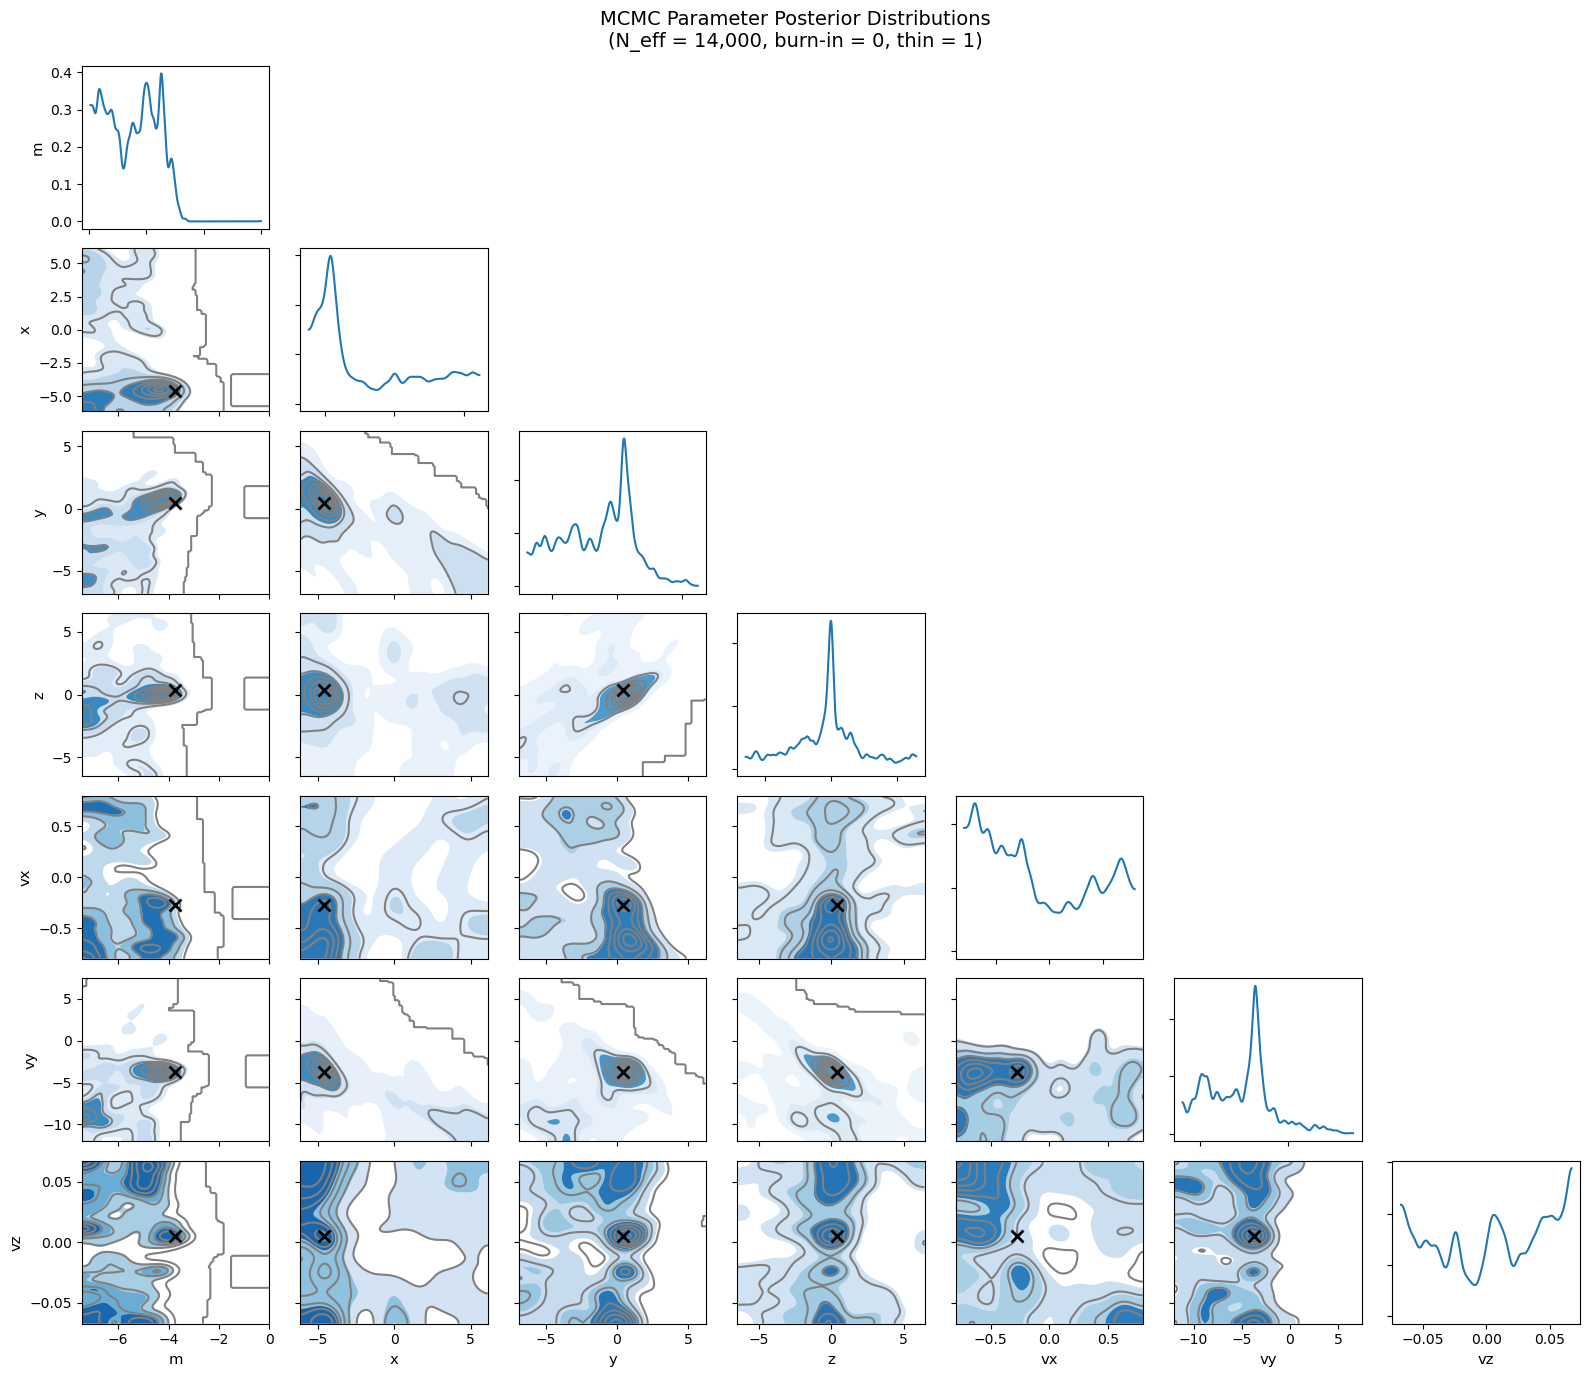

In [ ]:
reference_values_scaled = scale_param(m_0)
reference_values_scaled[0] = np.log10(reference_values_scaled[0])  # Scale mass logarithmically
param_labels = ['m', 'x', 'y', 'z', 'vx', 'vy', 'vz']
param_data = {label: flat_samples[:, i] for i, label in enumerate(param_labels)}
reference_dict = {label: reference_values_scaled[i] for i, label in enumerate(param_labels)}

print("Creating corner plot with KDE contours and reference values...")

fig, axes = plt.subplots(7, 7, figsize=(16, 14))

az.plot_pair(
    param_data,
    marginals=True,
    reference_values=reference_dict,
    reference_values_kwargs={
        'color': 'red', 
        'ms': 8,
        'marker': 'x',
        'markeredgewidth': 2
    },
    kind='kde',
    kde_kwargs={
        'hdi_probs': [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
        'contourf_kwargs': {'cmap': 'Blues'},
    },
    ax=axes,
    textsize=10
)

plt.suptitle(f'MCMC Parameter Posterior Distributions\n'
            f'(N_eff = {len(flat_samples):,}, burn-in = {discard_burn}, thin = {thin_interval})', 
            fontsize=14, y=0.98)

plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()


## 4.5 Plotting the Chains

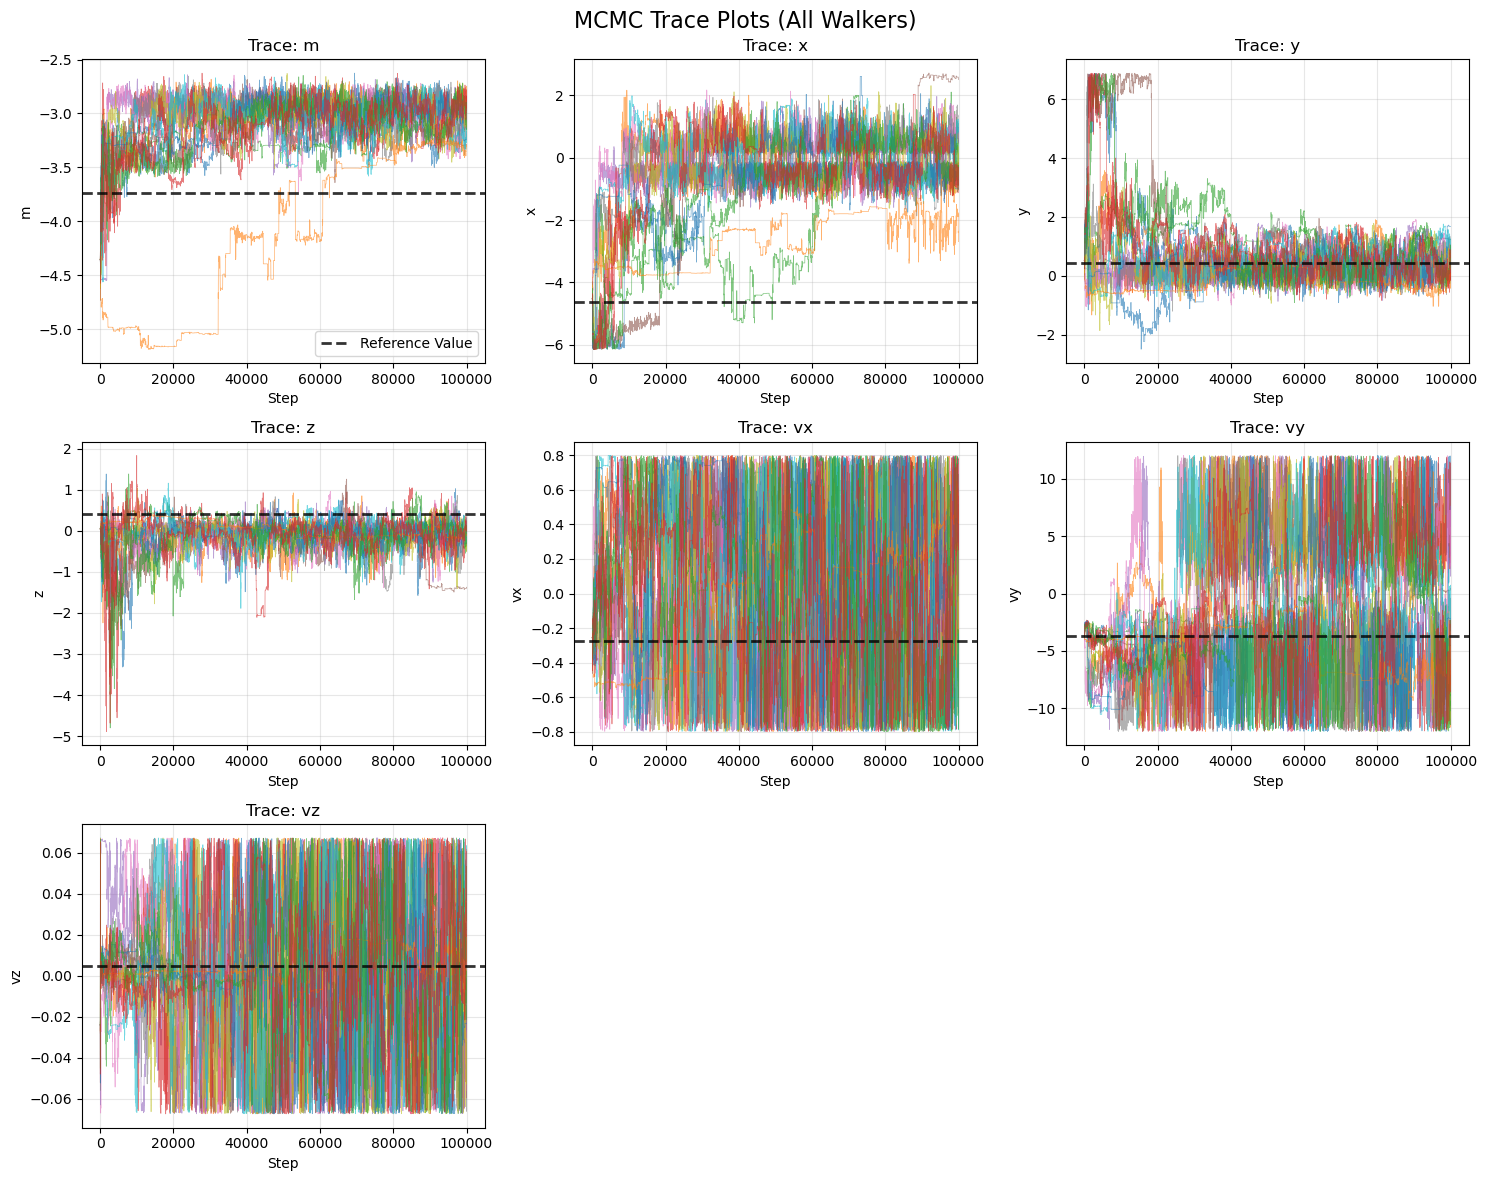

In [50]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

chain_full = sampler.get_chain()
labels = ["m", "x", "y", "z", "vx", "vy", "vz"]

for i in range(n_dim):
    ax = axes[i]
    
    for walker in range(14):
        ax.plot(chain_full[:, walker, i], alpha=0.6, linewidth=0.5)
    
    ax.axhline(reference_values_scaled[i], color='black', linestyle='--', alpha=0.8, 
            linewidth=2, label='Reference Value' if i == 0 else '')    
    ax.set_xlabel('Step')
    ax.set_ylabel(f'{labels[i]}')
    ax.set_title(f'Trace: {labels[i]}')
    ax.grid(True, alpha=0.3)
    
    if i == 0:
        ax.legend()

for i in range(n_dim, len(axes)):
    axes[i].remove()

plt.suptitle('MCMC Trace Plots (All Walkers)', fontsize=16)
plt.tight_layout()
plt.show()

# 5. Watermark

- For version of libraries used.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import numba
import arviz
import astroquery
import cofi

def print_versions():
    print("Library Versions:")
    print(f"{'numpy':<15}: {np.__version__}")
    print(f"{'matplotlib':<15}: {plt.matplotlib.__version__}")
    print(f"{'tqdm':<15}: {tqdm.__version__}")
    print(f"{'numba':<15}: {numba.__version__}")
    print(f"{'arviz':<15}: {arviz.__version__}")
    print(f"{'astroquery':<15}: {astroquery.__version__}")
    print(f"{'cofi':<15}: {cofi.__version__}")

print_versions()

Library Versions:
numpy          : 2.2.3
matplotlib     : 3.10.1
tqdm           : 4.67.1
numba          : 0.61.2
arviz          : 0.21.0
astroquery     : 0.4.10
cofi           : 0.2.4
